# 1: Cross-Model Summary of Core Metrics

We compare the predictive performance of six models (GCN, GAT, GraphSAGE; each under both random and temporal splits) using core evaluation metrics. This section consolidates:
- Mean and standard deviation of key performance metrics across seeds
- Model-wise comparison of F1-macro, F1-illicit, MCC, Balanced Accuracy, and Validation Accuracy

This allows us to identify models with:
- Superior overall classification performance
- Stability across seeds (via low standard deviation)
- Tradeoffs between precision and recall in the illicit class (critical for AML settings)

---


In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For statistical testing
from scipy.stats import ttest_rel, wilcoxon

# For consistent plot aesthetics
sns.set(style="whitegrid", font_scale=1.2)

# Define models and their JSON export paths
MODEL_PATHS = {
    "GAT-Random":     "../models_v2/GAT",
    "GCN-Random":     "../models_v2/GCN",
    "SAGE-Random":    "../models_v2/SAGE",
    "GAT-Temporal":   "../model_temporal/GAT",
    "GCN-Temporal":   "../model_temporal/GCN",
    "SAGE-Temporal":  "../model_temporal/SAGE"
}

# Seed list (assumed consistent across models)
SEEDS = [42, 123, 777, 2023, 31415]


# 2: Load JSON Logs from All Models

In this section, we load per-seed evaluation metrics from all six models. These metrics include validation accuracy, class-wise F1 scores, balanced accuracy, MCC, and others. Each JSON file was exported from the respective model’s evaluation notebook.


In [ ]:
# Initialize a dictionary to hold DataFrames for each model
model_metrics = {}

# Metrics to retain for analysis
selected_metrics = [
    'val_acc', 'bal_acc', 'f1_macro', 'f1_illicit',
    'precision_illicit', 'recall_illicit', 'mcc'
]

for model_name, path in MODEL_PATHS.items():
    json_path = os.path.join(path, "seed_metrics.json")
    
    with open(json_path, "r") as f:
        raw = json.load(f)

    # Convert list of dicts → DataFrame
    df = pd.DataFrame(raw)

    # Only retain selected columns
    existing = [m for m in selected_metrics if m in df.columns]
    df = df[existing]

    model_metrics[model_name] = df
    print(f"{model_name} loaded with shape: {df.shape}")


GAT-Random loaded with shape: (5, 7)
GCN-Random loaded with shape: (5, 7)
SAGE-Random loaded with shape: (5, 7)
GAT-Temporal loaded with shape: (5, 7)
GCN-Temporal loaded with shape: (5, 7)
SAGE-Temporal loaded with shape: (5, 7)


# 3. Summary Table of Core Metrics Across Models

This section aggregates per-seed evaluation results into a comparative summary table for all models. For each model and each selected metric, we compute the mean and standard deviation across the 5 random seeds used in training and validation.

This aggregation serves three purposes:

Model stability assessment: By examining the standard deviation, we identify models whose performance varies substantially across different random initializations.

Performance benchmarking: The table allows direct comparison of core metrics such as F1-macro, MCC, and balanced accuracy; all of which are essential in highly imbalanced settings such as AML.

This tabulated summary forms the basis for later visualizations and statistical significance testing (e.g., paired t-tests between models).

In [5]:
# SECTION 3: Cross-Model Summary Table (Mean ± Std)

summary_rows = []

for model_name, df in model_metrics.items():
    row = {"Model": model_name}
    for metric in selected_metrics:
        if metric in df.columns:
            mean_val = df[metric].mean()
            std_val = df[metric].std()
            row[metric] = f"{mean_val:.4f} ± {std_val:.4f}"
        else:
            row[metric] = "N/A"
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index("Model")[selected_metrics]  # consistent ordering

# Display formatted summary table
display(summary_df.style.set_caption("Table 1: Mean ± Std of Core Metrics Across Models"))

,val_acc,bal_acc,f1_macro,f1_illicit,precision_illicit,recall_illicit,mcc
Model,,,,,,,
GAT-Random,0.9529 ± 0.0044,0.7987 ± 0.0271,0.8444 ± 0.0200,0.9743 ± 0.0023,0.9589 ± 0.0055,0.9903 ± 0.0018,0.7040 ± 0.0330
GCN-Random,0.9510 ± 0.0019,0.7987 ± 0.0074,0.8407 ± 0.0064,0.9732 ± 0.0010,0.9590 ± 0.0015,0.9879 ± 0.0016,0.6932 ± 0.0125
SAGE-Random,0.9752 ± 0.0011,0.8989 ± 0.0051,0.9251 ± 0.0034,0.9864 ± 0.0006,0.9791 ± 0.0011,0.9938 ± 0.0009,0.8532 ± 0.0067
GAT-Temporal,0.9396 ± 0.0167,0.7371 ± 0.0227,0.7357 ± 0.0424,0.9678 ± 0.0092,0.9692 ± 0.0025,0.9665 ± 0.0170,0.4749 ± 0.0832
GCN-Temporal,0.9518 ± 0.0011,0.6648 ± 0.0051,0.7139 ± 0.0065,0.9748 ± 0.0006,0.9600 ± 0.0006,0.9900 ± 0.0006,0.4594 ± 0.0135
SAGE-Temporal,0.9670 ± 0.0010,0.7844 ± 0.0017,0.8278 ± 0.0041,0.9826 ± 0.0006,0.9741 ± 0.0002,0.9914 ± 0.0010,0.6664 ± 0.0096


# 4. Visual Comparison of Model Performance

This section provides a visual summary of model performance across core evaluation metrics using bar plots. Each bar represents the mean score across five random seeds, with error bars indicating standard deviation.


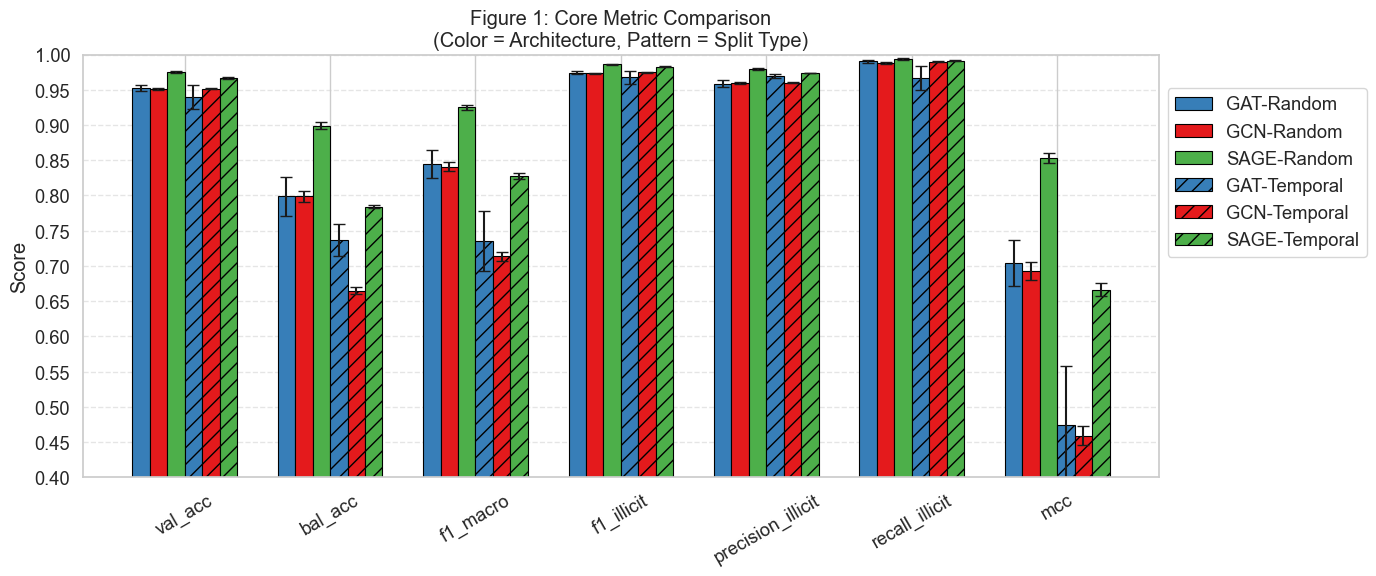

In [31]:
# Color assignment for architecture (colorblind-safe)
model_color = {
    "GAT": "#377eb8",   # blue
    "GCN": "#e41a1c",   # red
    "SAGE": "#4daf4a"   # green
}

# Hatch pattern for split type
split_hatch = {
    "Random": "",
    "Temporal": "//"
}

plt.figure(figsize=(14, 6))
x = np.arange(len(selected_metrics))
bar_width = 0.12
offsets = np.linspace(-0.3, 0.3, len(mean_df))  # spacing

for i, model in enumerate(mean_df.index):
    arch = model.split("-")[0]
    split = model.split("-")[1]

    plt.bar(
        x + offsets[i],
        mean_df.loc[model],
        yerr=std_df.loc[model],
        width=bar_width,
        color=model_color[arch],
        hatch=split_hatch[split],
        edgecolor="black",
        linewidth=0.8,
        capsize=4,
        label=model
    )

plt.xticks(x, selected_metrics, rotation=30)
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.yticks(np.arange(0.4, 1.05, 0.05))
plt.title("Figure 1: Core Metric Comparison\n(Color = Architecture, Pattern = Split Type)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()



# 5. Metrc Distribution Boxplot (Per Seed)

This section visualizes per-seed metric distributions for each model using boxplots.

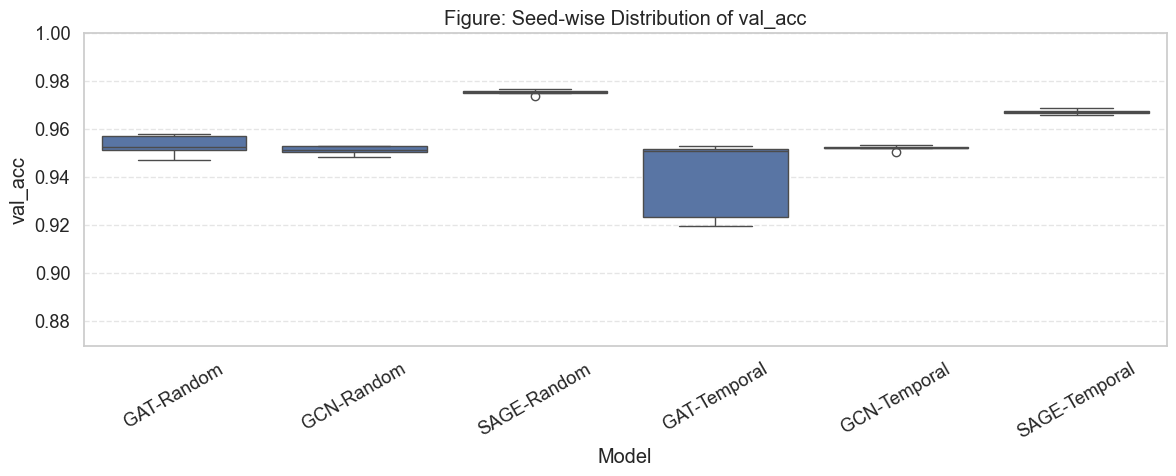

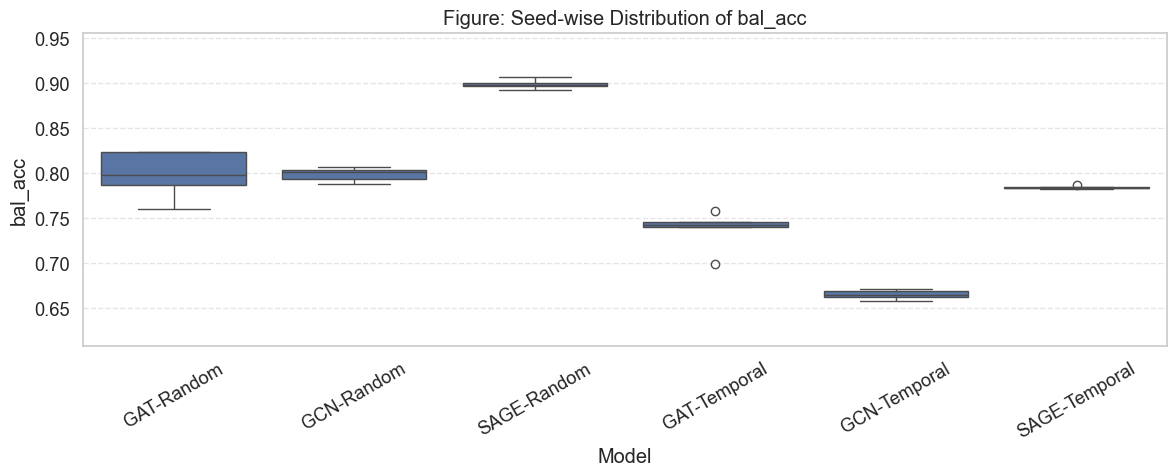

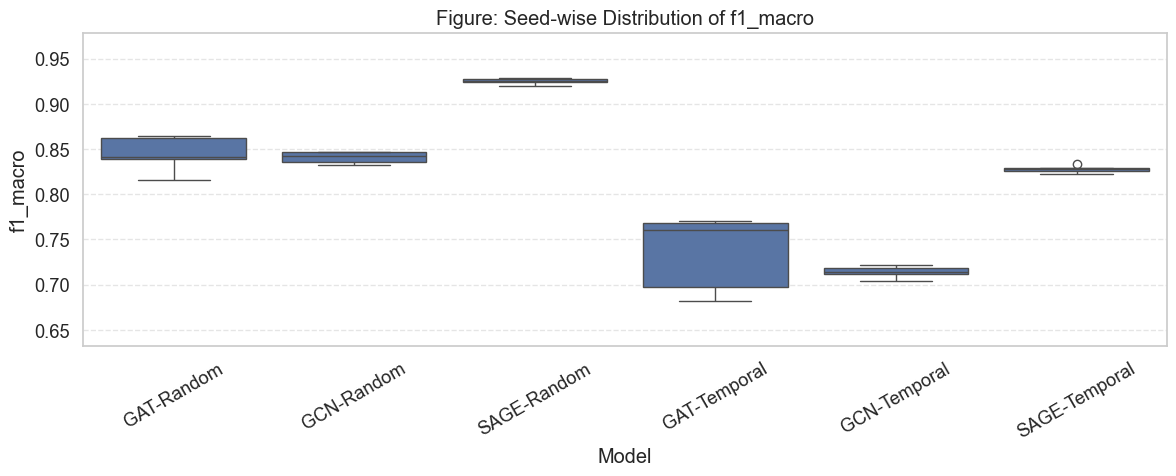

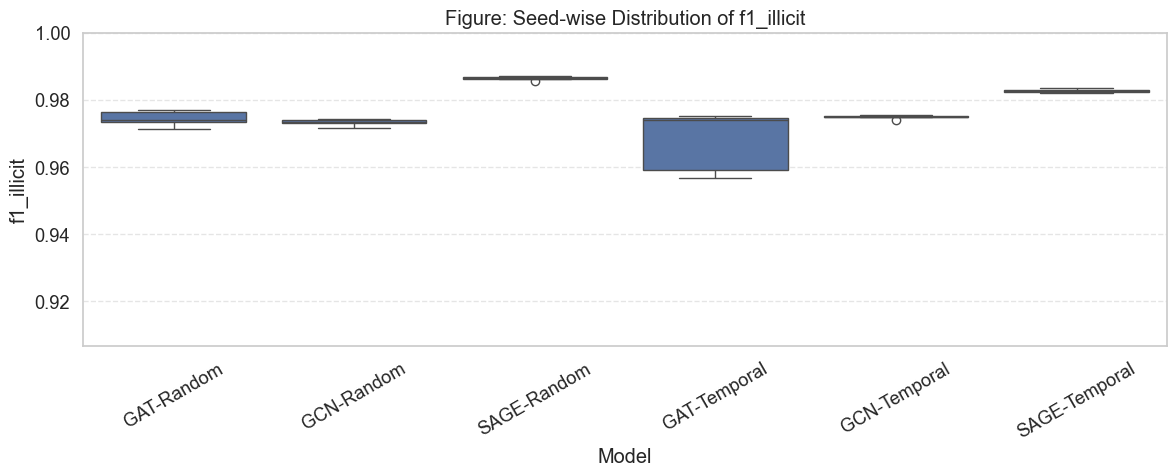

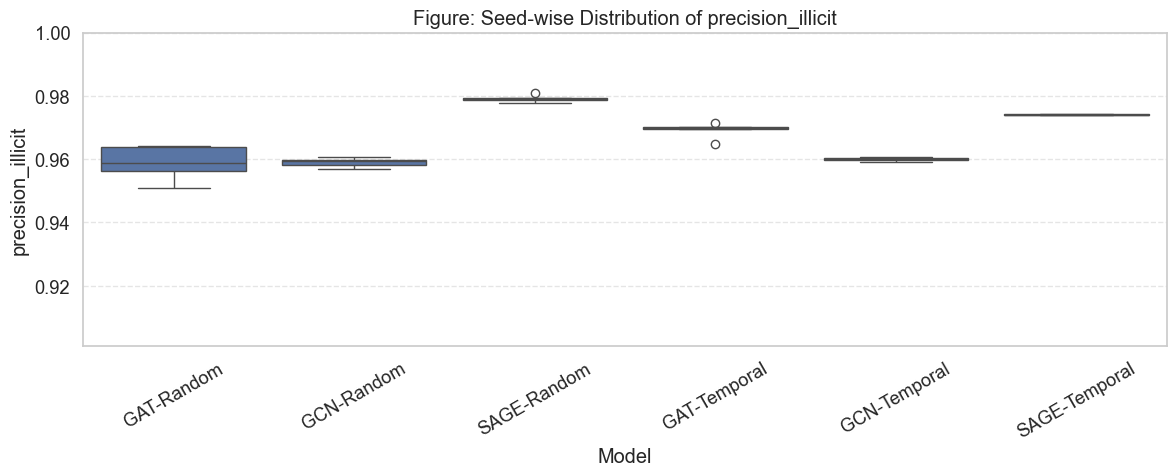

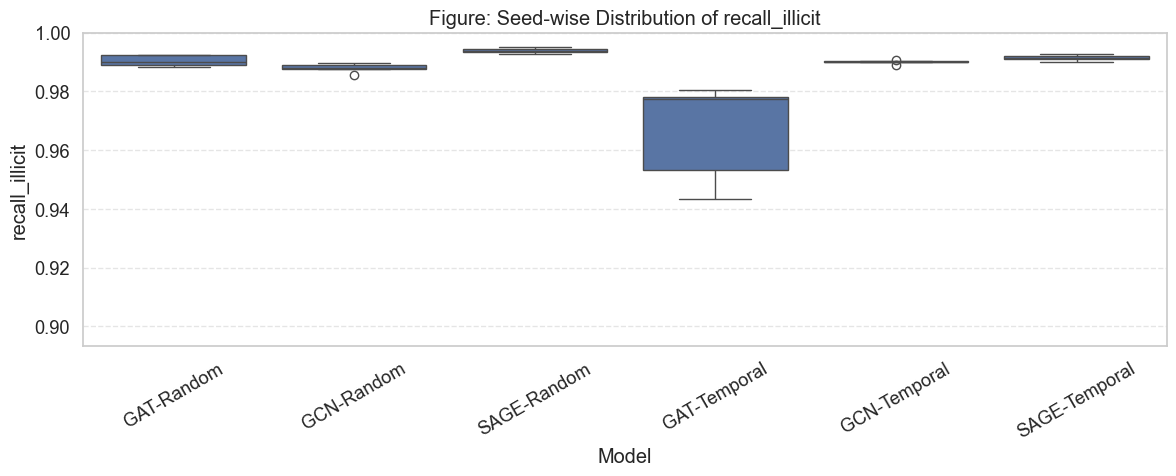

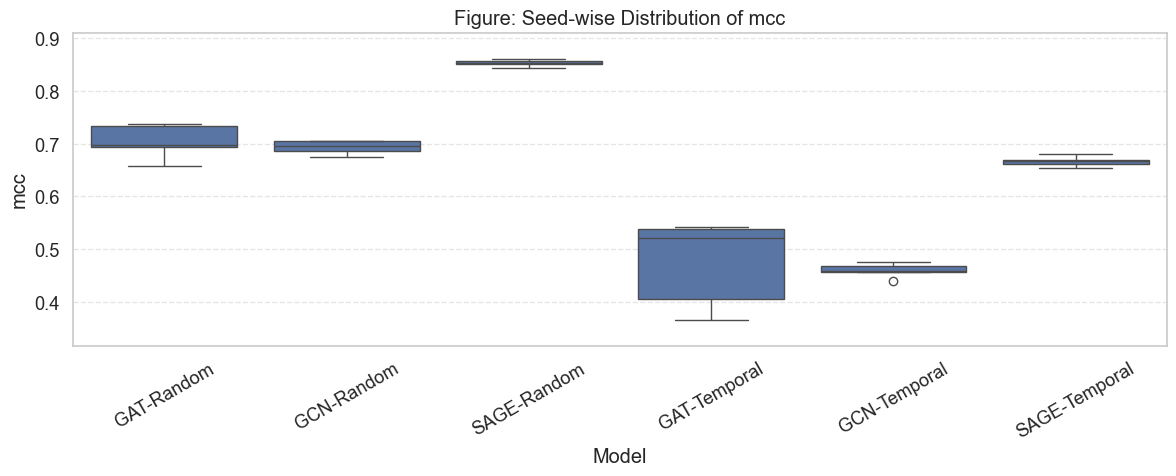

In [18]:
for metric in selected_metrics:
    long_data = []

    for model_name, df in model_metrics.items():
        if metric in df.columns:
            for val in df[metric]:
                long_data.append({"Model": model_name, "Metric": metric, "Value": val})

    if not long_data:
        print(f"Skipping {metric} — no data available.")
        continue

    metric_df = pd.DataFrame(long_data)
    min_val = metric_df["Value"].min()
    max_val = metric_df["Value"].max()

    plt.figure(figsize=(12, 5))
    sns.boxplot(data=metric_df, x="Model", y="Value")
    plt.title(f"Figure: Seed-wise Distribution of {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=30)

    plt.ylim(max(0.0, min_val - 0.05), min(1.0, max_val + 0.05))
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# 6. Statistical Significance Testing (Paired t-test & Wilcoxon Signed-Rank Test)

This section quantifies whether performance differences between models are statistically significant using:

1) Paired t-test (parametric): Assumes metric differences are normally distributed.

2) Wilcoxon signed-rank test (non-parametric): Robust to outliers and non-normality.

We conduct pairwise comparisons across models, per metric, to evaluate whether performance improvements are statistically meaningful, whether architectural or temporal differences are significant.

In [19]:
from itertools import combinations
from scipy.stats import ttest_rel, wilcoxon

alpha = 0.05  # significance threshold

for metric in selected_metrics:
    print(f"\n=== Metric: {metric} ===")
    models_with_metric = [m for m in model_metrics if metric in model_metrics[m].columns]

    for m1, m2 in combinations(models_with_metric, 2):
        vals1 = model_metrics[m1][metric].values
        vals2 = model_metrics[m2][metric].values

        if len(vals1) != len(vals2):
            print(f"  Skipping {m1} vs {m2} due to unequal seeds.")
            continue

        # Paired t-test
        t_stat, t_pval = ttest_rel(vals1, vals2)

        # Wilcoxon signed-rank test (non-parametric)
        try:
            w_stat, w_pval = wilcoxon(vals1, vals2)
        except ValueError:
            w_pval = np.nan  # can't compute Wilcoxon if all diffs are 0

        signif_t = "*" if t_pval < alpha else ""
        signif_w = "*" if w_pval < alpha else ""

        print(f"  {m1} vs {m2}: t-test p={t_pval:.4f}{signif_t} | Wilcoxon p={w_pval:.4f}{signif_w}")



=== Metric: val_acc ===
  GAT-Random vs GCN-Random: t-test p=0.4338 | Wilcoxon p=0.6250
  GAT-Random vs SAGE-Random: t-test p=0.0007* | Wilcoxon p=0.0625
  GAT-Random vs GAT-Temporal: t-test p=0.0928 | Wilcoxon p=0.0625
  GAT-Random vs GCN-Temporal: t-test p=0.5072 | Wilcoxon p=0.6250
  GAT-Random vs SAGE-Temporal: t-test p=0.0035* | Wilcoxon p=0.0625
  GCN-Random vs SAGE-Random: t-test p=0.0000* | Wilcoxon p=0.0625
  GCN-Random vs GAT-Temporal: t-test p=0.2133 | Wilcoxon p=0.8125
  GCN-Random vs GCN-Temporal: t-test p=0.4129 | Wilcoxon p=0.6250
  GCN-Random vs SAGE-Temporal: t-test p=0.0001* | Wilcoxon p=0.0625
  SAGE-Random vs GAT-Temporal: t-test p=0.0100* | Wilcoxon p=0.0625
  SAGE-Random vs GCN-Temporal: t-test p=0.0000* | Wilcoxon p=0.0625
  SAGE-Random vs SAGE-Temporal: t-test p=0.0000* | Wilcoxon p=0.0625
  GAT-Temporal vs GCN-Temporal: t-test p=0.1619 | Wilcoxon p=0.0625
  GAT-Temporal vs SAGE-Temporal: t-test p=0.0223* | Wilcoxon p=0.0625
  GCN-Temporal vs SAGE-Temporal: t-t

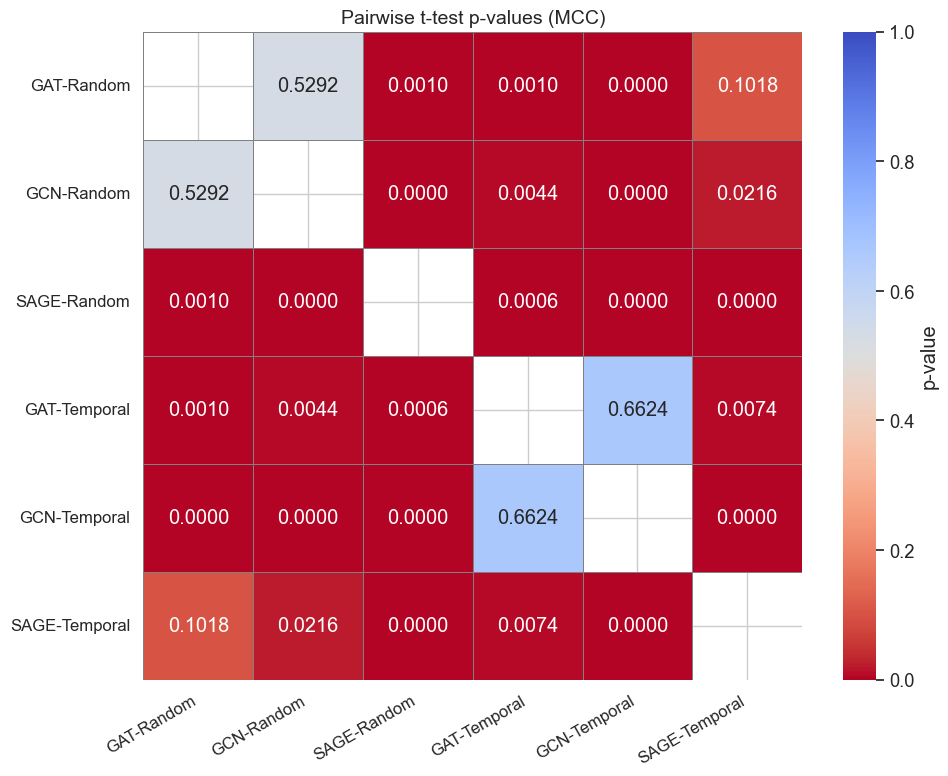

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define models
models = [
    "GAT-Random", "GCN-Random", "SAGE-Random",
    "GAT-Temporal", "GCN-Temporal", "SAGE-Temporal"
]

# Lower triangle only
pvals_lower = [
    [np.nan,       np.nan,       np.nan,       np.nan,       np.nan,       np.nan],
    [0.5292,       np.nan,       np.nan,       np.nan,       np.nan,       np.nan],
    [0.0010,       0.0000,       np.nan,       np.nan,       np.nan,       np.nan],
    [0.0010,       0.0044,       0.0006,       np.nan,       np.nan,       np.nan],
    [0.0000,       0.0000,       0.0000,       0.6624,       np.nan,       np.nan],
    [0.1018,       0.0216,       0.0000,       0.0074,       0.0000,       np.nan]
]

# Convert to array and mirror manually
pvals = np.array(pvals_lower)
pvals = np.tril(pvals) + np.tril(pvals, -1).T  # only copy lower to upper
np.fill_diagonal(pvals, np.nan)

# Create DataFrame
pval_df = pd.DataFrame(pvals, index=models, columns=models)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pval_df,
    annot=True,
    fmt=".4f",
    cmap="coolwarm_r",
    linewidths=0.5,
    linecolor="grey",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "p-value"}
)
plt.title("Pairwise t-test p-values (MCC)", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


# 7. Cross-Model False Positive / False Negative Error Distribution

While prior sections quantified how well models performed, this section explores how they made mistakes:

1) Do some models generate more false positives (FPs) than others?

2) Are false negatives (FNs) temporally or structurally biased?

3) Can we observe consistent error patterns across seeds or architectures?


## 7.1 FP/FN Count Comparison Across Models

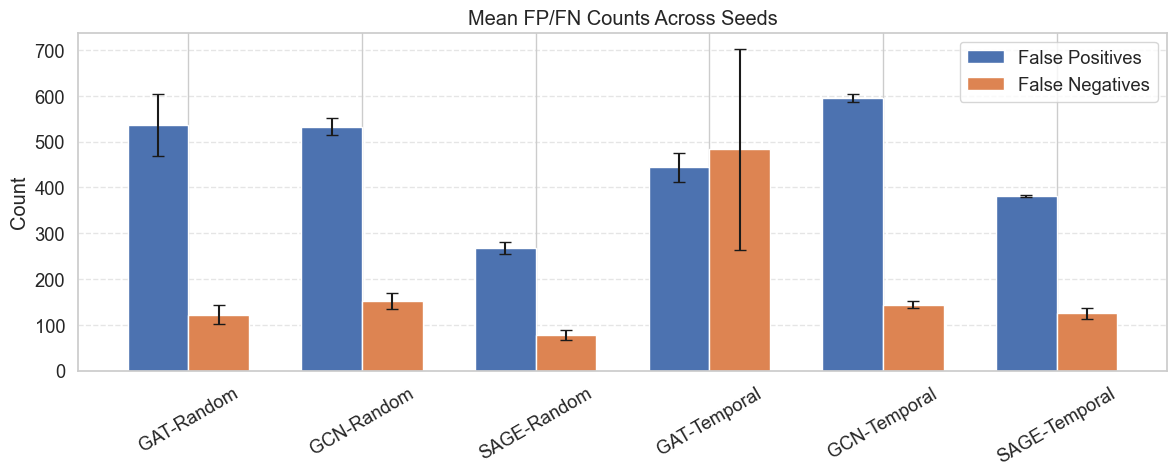

In [21]:

import json
import os
import numpy as np
import matplotlib.pyplot as plt

model_dirs = {
    "GAT-Random": "../models_v2/GAT",
    "GCN-Random": "../models_v2/GCN",
    "SAGE-Random": "../models_v2/SAGE",
    "GAT-Temporal": "../model_temporal/GAT",
    "GCN-Temporal": "../model_temporal/GCN",
    "SAGE-Temporal": "../model_temporal/SAGE",
}

fp_stats = {}
fn_stats = {}

for model_name, path in model_dirs.items():
    with open(os.path.join(path, "fp_counts.json")) as f:
        fps = np.array(json.load(f))
    with open(os.path.join(path, "fn_counts.json")) as f:
        fns = np.array(json.load(f))

    fp_stats[model_name] = (fps.mean(), fps.std())
    fn_stats[model_name] = (fns.mean(), fns.std())

# Plotting
labels = list(model_dirs.keys())
x = np.arange(len(labels))
width = 0.35

fp_means = [fp_stats[m][0] for m in labels]
fp_stds  = [fp_stats[m][1] for m in labels]
fn_means = [fn_stats[m][0] for m in labels]
fn_stds  = [fn_stats[m][1] for m in labels]

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, fp_means, width, yerr=fp_stds, capsize=4, label='False Positives')
plt.bar(x + width/2, fn_means, width, yerr=fn_stds, capsize=4, label='False Negatives')
plt.xticks(x, labels, rotation=30)
plt.ylabel("Count")
plt.title("Mean FP/FN Counts Across Seeds")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 7.2 Temporal Distribution of FP/FN across Models

We analyze how false positives (FPs) and false negatives (FNs) are distributed across time steps for each model. This helps answer:

Do some models fail more in early vs. late stages of the transaction graph? (SilkRoad FBI shutdown)

Are temporal models more robust to future time steps?

Do FPs and FNs follow complementary patterns?

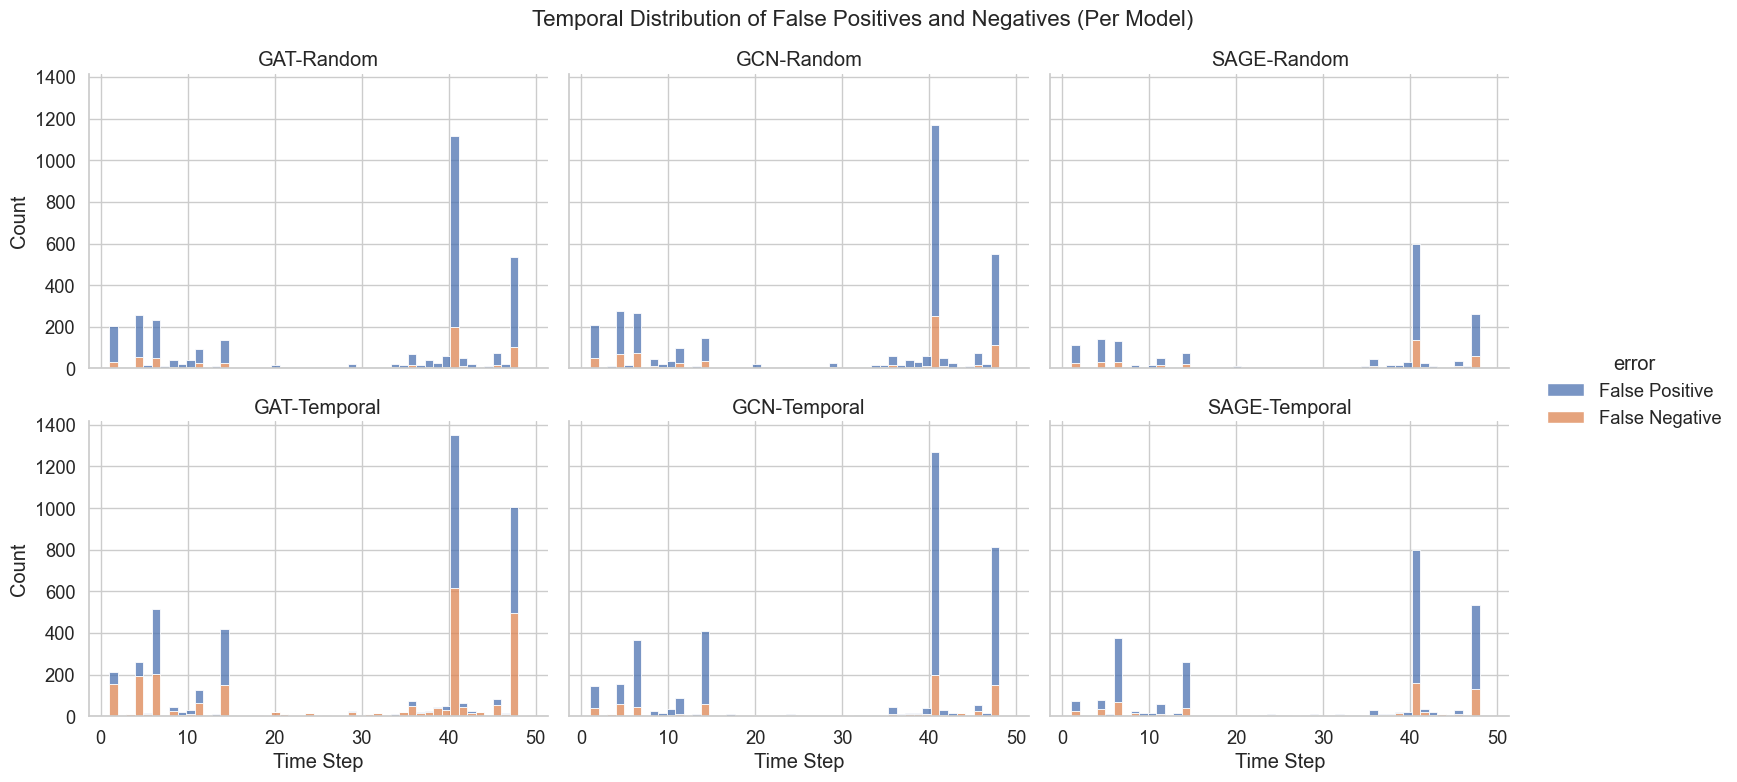

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load all model data
model_dirs = {
    "GAT-Random": "../models_v2/GAT",
    "GCN-Random": "../models_v2/GCN",
    "SAGE-Random": "../models_v2/SAGE",
    "GAT-Temporal": "../model_temporal/GAT",
    "GCN-Temporal": "../model_temporal/GCN",
    "SAGE-Temporal": "../model_temporal/SAGE",
}

time_data = []

for model_name, path in model_dirs.items():
    with open(os.path.join(path, "fp_time.json")) as f:
        fp_times = json.load(f)
    with open(os.path.join(path, "fn_time.json")) as f:
        fn_times = json.load(f)

    for t in fp_times:
        time_data.append({"time": int(t), "error": "False Positive", "model": model_name})
    for t in fn_times:
        time_data.append({"time": int(t), "error": "False Negative", "model": model_name})

df_time = pd.DataFrame(time_data)

# ✅ Faceted histogram by model
g = sns.displot(
    data=df_time,
    x="time",
    hue="error",
    col="model",
    kind="hist",
    multiple="stack",
    bins=49,
    col_wrap=3,
    height=4,
    aspect=1.3
)

g.set_axis_labels("Time Step", "Count")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Temporal Distribution of False Positives and Negatives (Per Model)", fontsize=16)
plt.show()


## 7.3 Normalised FP/FN Error Rates Over Time

Raw FP/FN counts alone can be misleading due to variations in node volume across time steps. This section normalizes error counts by the number of nodes present at each time step to compute:

FP rate = FP count at step t ÷ total nodes at t

FN rate = FN count at step t ÷ total nodes at t

This reveals:

Time steps where models are disproportionately error-prone

Whether certain models struggle more in sparse/dense time interval

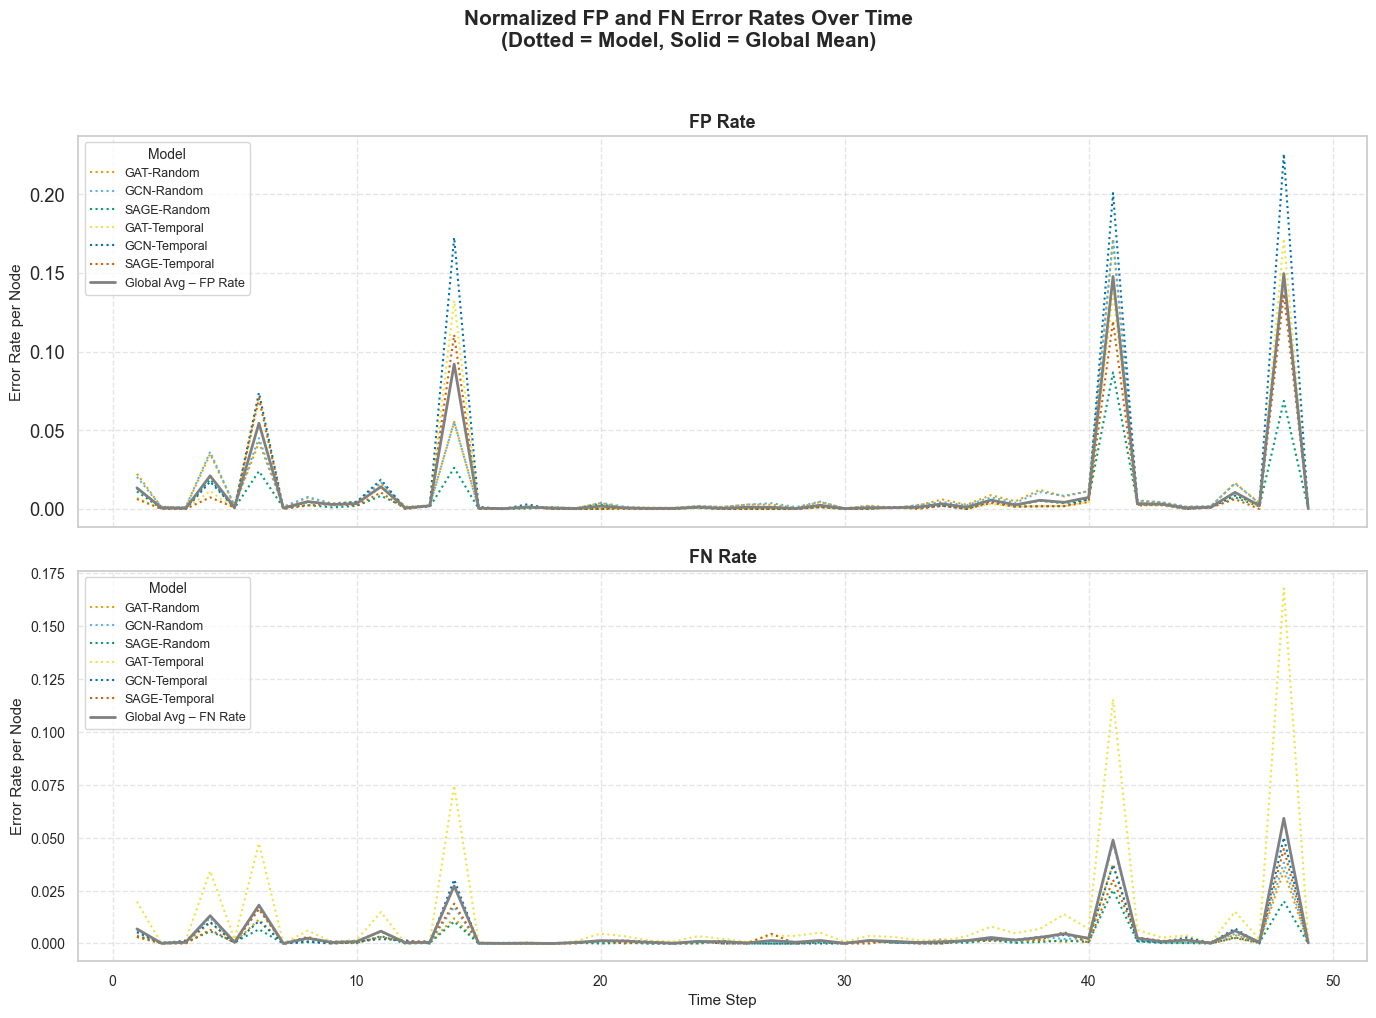

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign distinct colors to models
color_cycle = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00"
]
model_list = list(df_rates["model"].unique())
model_colors = dict(zip(model_list, color_cycle))

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

for i, error_type in enumerate(["FP Rate", "FN Rate"]):
    ax = axes[i]
    for model in model_list:
        subset = df_rates[(df_rates["model"] == model) & (df_rates["error_type"] == error_type)]

        linestyle = "dotted"
        label = model
        color = model_colors[model]

        sns.lineplot(
            data=subset,
            x="time",
            y="rate",
            ax=ax,
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=1.5
        )

    # Add global average line
    mean_rates = (
        df_rates[df_rates["error_type"] == error_type]
        .groupby("time")["rate"]
        .mean()
        .reset_index()
    )

    sns.lineplot(
        data=mean_rates,
        x="time",
        y="rate",
        ax=ax,
        color="grey",
        label=f"Global Avg – {error_type}",
        linewidth=2.0,
        linestyle="solid"
    )

    ax.set_ylabel("Error Rate per Node", fontsize=11)
    ax.set_title(error_type, fontsize=13, weight="bold")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="upper left", fontsize=9, title="Model", title_fontsize=10)

axes[1].set_xlabel("Time Step", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.suptitle("Normalized FP and FN Error Rates Over Time\n(Dotted = Model, Solid = Global Mean)", fontsize=15, weight="bold", y=1.02)
plt.tight_layout()
plt.show()



# 8: Correlation Between Performance Metrics and Error Characteristics

This section examines whether model-level metrics (like F1_macro, MCC) are correlated with behavioral error patterns, such as total false positives, total false negatives, and FP/FN rates at specific time steps.

This helps answer:

1) Do models with higher F1_macro consistently make fewer false negatives?

2) Is MCC more sensitive to FP imbalance?

3) Are some metrics more predictive of time-dependent error surges?

## 8.1 Prepare Metric Averages and FP/FN Counts

In [37]:
import pandas as pd
import numpy as np
import json
import os

# Prepare correlation data table
rows = []

for model_name, path in model_dirs.items():
    # Load per-seed metrics
    with open(os.path.join(path, "seed_metrics.json")) as f:
        metrics = pd.DataFrame(json.load(f))

    # Load FP/FN counts
    with open(os.path.join(path, "fp_counts.json")) as f:
        fp = np.array(json.load(f))
    with open(os.path.join(path, "fn_counts.json")) as f:
        fn = np.array(json.load(f))

    # Store mean metrics and mean FP/FN counts
    row = {
        "model": model_name,
        "fp_mean": fp.mean(),
        "fn_mean": fn.mean()
    }

    for col in ["val_acc", "bal_acc", "f1_macro", "f1_illicit", "precision_illicit", "recall_illicit", "mcc"]:
        row[col] = metrics[col].mean() if col in metrics.columns else np.nan

    rows.append(row)

df_corr = pd.DataFrame(rows).set_index("model")
display(df_corr)


,fp_mean,fn_mean,val_acc,bal_acc,f1_macro,f1_illicit,precision_illicit,recall_illicit,mcc
model,,,,,,,,,
GAT-Random,536.0,122.0,0.952899,0.798680,0.844399,0.974329,0.958864,0.990322,0.703982
GCN-Random,532.6,152.2,0.950981,0.798729,0.840749,0.973242,0.958990,0.987926,0.693246
SAGE-Random,267.2,78.6,0.975247,0.898935,0.925098,0.986386,0.979117,0.993765,0.853166
GAT-Temporal,443.6,483.0,0.939552,0.737091,0.735726,0.967786,0.969161,0.966523,0.474870
GCN-Temporal,595.0,143.8,0.951804,0.664828,0.713923,0.974791,0.960011,0.990033,0.459430
SAGE-Temporal,380.8,124.8,0.967017,0.784354,0.827822,0.982632,0.974067,0.991350,0.666377


## 8.2 Correlation Heatmap (Metrics vs FP/FN)

We compute Pearson correlations between model-level performance metrics and FP/FN error counts across all six models.

This reveals which metrics negatively correlate with false positives/negatives (good), and which metrics fail to capture real-world error behavior (e.g., high val_acc but high FN)

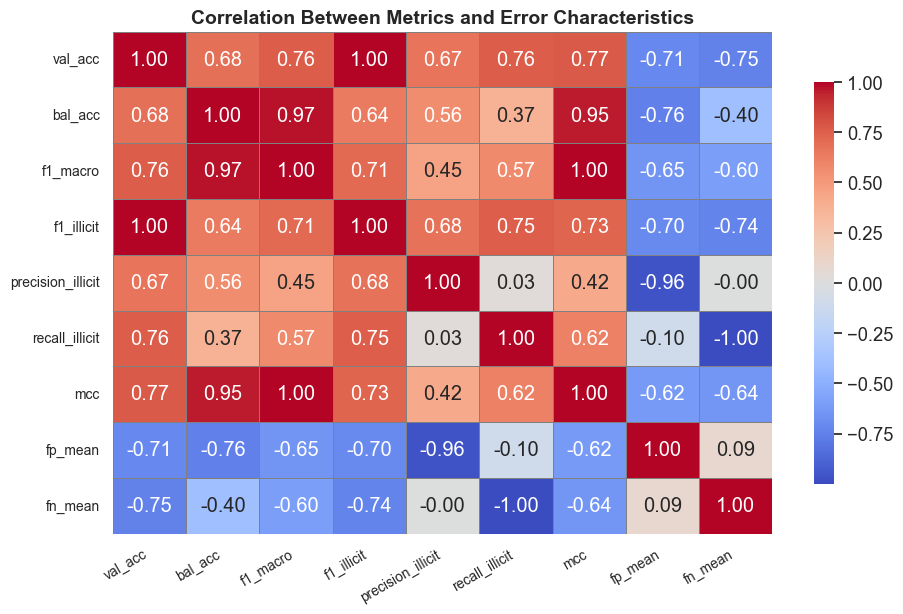

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset only numeric columns
corr_data = df_corr[[
    "val_acc", "bal_acc", "f1_macro", "f1_illicit",
    "precision_illicit", "recall_illicit", "mcc", 
    "fp_mean", "fn_mean"
]]

# Compute Pearson correlation matrix
corr_matrix = corr_data.corr(method="pearson")

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, linecolor="gray", cbar_kws={"shrink": 0.8})
plt.title("Correlation Between Metrics and Error Characteristics", fontsize=14, weight="bold")
plt.tight_layout()
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()


## 8.3 Metric to Metric Scatterplots
This section explores the relationships between performance metrics across all six GNN variants (GCN, GAT, GraphSAGE under both Random and Temporal splits). By visualizing these relationships, we aim to identify:

Trade-offs (e.g., precision vs. recall)

Co-dependencies between core metrics (e.g., MCC vs. F1)

Whether FP/FN error characteristics predict metric behavior

Useful for model-level multivariate analysis and help determine whether certain metrics can be substituted or are collinear.

In [47]:
import os
import json
import numpy as np
import pandas as pd

model_sources = {
    "GAT-Random": "../models_v2/GAT",
    "GCN-Random": "../models_v2/GCN",
    "SAGE-Random": "../models_v2/SAGE",
    "GAT-Temporal": "../model_temporal/GAT",
    "GCN-Temporal": "../model_temporal/GCN",
    "SAGE-Temporal": "../model_temporal/SAGE",
}

records = []

for model_name, model_dir in model_sources.items():
    # Load seed metrics
    with open(os.path.join(model_dir, "seed_metrics.json")) as f:
        seed_metrics = json.load(f)
    df = pd.DataFrame(seed_metrics)
    means = df.mean().to_dict()

    # Load FP/FN counts
    try:
        with open(os.path.join(model_dir, "fp_counts.json")) as f:
            fp_counts = np.array(json.load(f))
        with open(os.path.join(model_dir, "fn_counts.json")) as f:
            fn_counts = np.array(json.load(f))

        means["fp_mean"] = fp_counts.mean()
        means["fn_mean"] = fn_counts.mean()
    except Exception as e:
        print(f"Warning: Could not load FP/FN counts for {model_name}. Error: {e}")
        means["fp_mean"] = np.nan
        means["fn_mean"] = np.nan

    # Add split and model for metadata
    means["model"] = model_name.split("-")[0]
    means["split"] = model_name.split("-")[1]

    records.append(means)

df_all_metrics = pd.DataFrame(records)


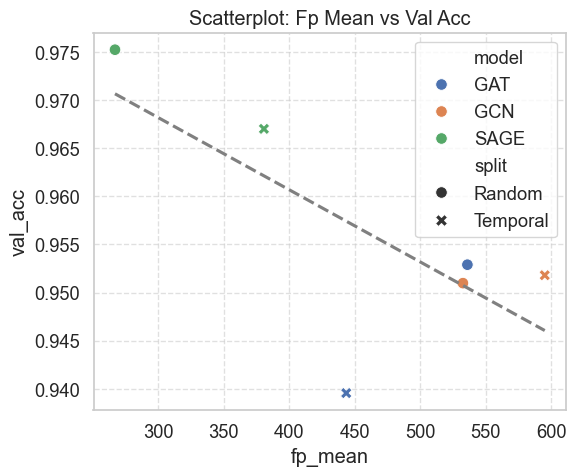

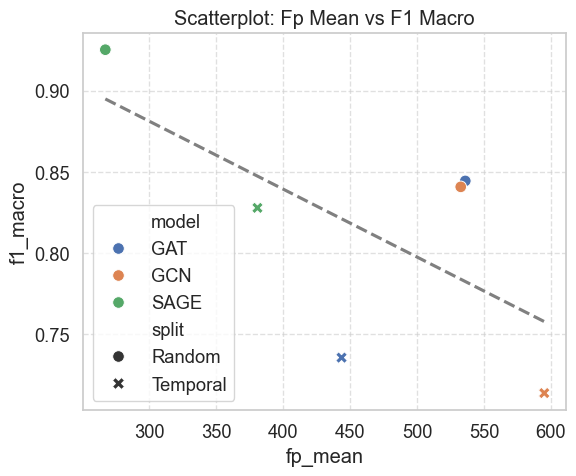

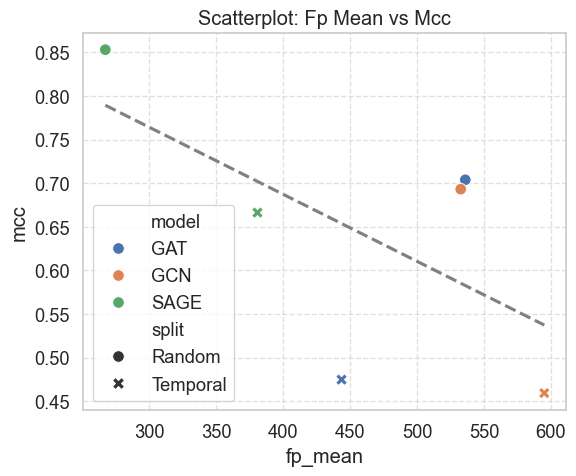

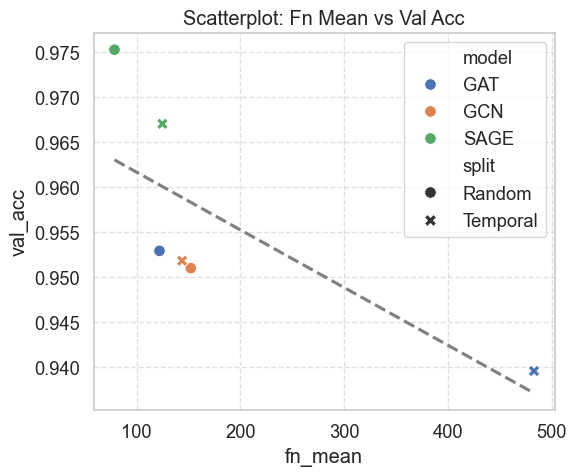

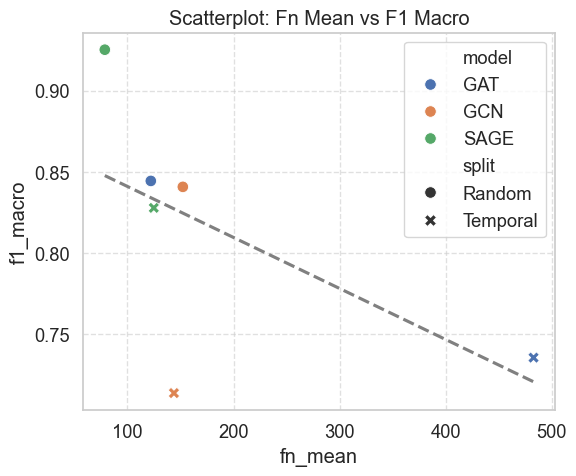

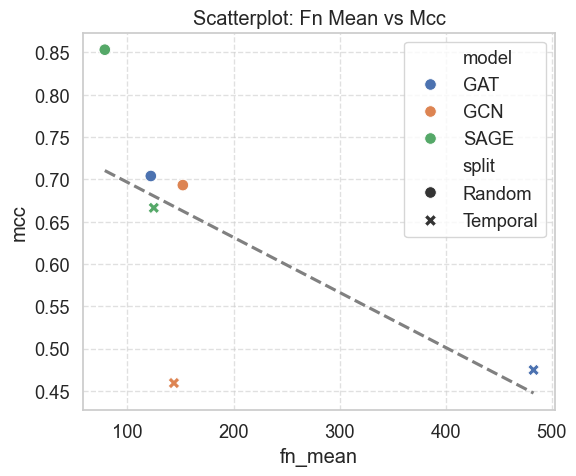

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

scatter_pairs = [
    ("fp_mean", "val_acc"),
    ("fp_mean", "f1_macro"),
    ("fp_mean", "mcc"),
    ("fn_mean", "val_acc"),
    ("fn_mean", "f1_macro"),
    ("fn_mean", "mcc"),
]

for x, y in scatter_pairs:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df_all_metrics, x=x, y=y, hue="model", style="split", s=70)
    sns.regplot(data=df_all_metrics, x=x, y=y, scatter=False, ci=None, color="gray", line_kws={"linestyle": "dashed"})
    plt.title(f"Scatterplot: {x.replace('_',' ').title()} vs {y.replace('_',' ').title()}")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


# 9. CSV

In [2]:
import os
import json
import pandas as pd

# Define config
base_folders = {
    "GAT-Random": "../model_randomsplit/GAT",
    "GCN-Random": "../model_randomsplit/GCN",
    "SAGE-Random": "../model_randomsplit/SAGE",
    "GAT-Temporal": "../model_temporal/GAT",
    "GCN-Temporal": "../model_temporal/GCN",
    "SAGE-Temporal": "../model_temporal/SAGE"
}
output_dir = "../results"
os.makedirs(output_dir, exist_ok=True)

# Loop through models
for model_name, path in base_folders.items():
    json_path = os.path.join(path, "seed_metrics.json")
    
    if not os.path.exists(json_path):
        print(f"[!] Missing: {json_path}")
        continue

    with open(json_path, "r") as f:
        metrics = json.load(f)

    if not isinstance(metrics, list):
        print(f"[!] Unexpected format in {json_path}")
        continue

    # Attach seed index (assumes order matches known seeds)
    seed_list = [42, 123, 777, 2023, 31415]
    for i, row in enumerate(metrics):
        row["seed"] = seed_list[i] if i < len(seed_list) else f"unknown_{i}"

    df = pd.DataFrame(metrics)

    out_path = os.path.join(output_dir, f"{model_name}_metrics.csv")
    df.to_csv(out_path, index=False)
    print(f"✅ Saved: {out_path}")


✅ Saved: ../results\GAT-Random_metrics.csv
✅ Saved: ../results\GCN-Random_metrics.csv
✅ Saved: ../results\SAGE-Random_metrics.csv
✅ Saved: ../results\GAT-Temporal_metrics.csv
✅ Saved: ../results\GCN-Temporal_metrics.csv
✅ Saved: ../results\SAGE-Temporal_metrics.csv


In [1]:
import torch
import torch_geometric
import sys

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")


Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PyTorch version: 2.7.0+cu118
PyTorch Geometric version: 2.6.1
